# Proyecto Parcial:
## Predictor de casos confirmados y muertes por Covid-19 en Arequipa y en Perú
### Autor: Anthony Benavides Arce

In [1]:
##Funciones Auxiliares para guardar las imagenes ploteadas

# Common imports
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas  as pd

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Obteniendo los datos
Los datos usados en este proyecto fueron obtenidos del siguiente repositorio: https://github.com/jmcastagnetto/covid-19-peru-data/blob/main/datos. Este repositorio cuenta con datos oficiales del MINSA, los cuales son libres de uso y actualizados.

Cargar el csv del link del repositorio de datos covid-19

In [2]:
url = 'https://raw.githubusercontent.com/jmcastagnetto/covid-19-peru-data/main/datos/covid-19-peru-data.csv'
covid_data = pd.read_csv(url)
covid_data.tail()

,country,iso3c,region,date,confirmed,deaths,recovered,total_tests,negative_tests,pcr_test_positive,serological_test_positive,pcr_serological_test_positive
5634,Peru,PER,San Martín,2020-10-20,20016.0,721.0,NaN,80729.0,60713.0,2755.0,17261.0,NaN
5635,Peru,PER,Tacna,2020-10-20,12762.0,225.0,NaN,68155.0,55393.0,1609.0,11153.0,NaN
5636,Peru,PER,Tumbes,2020-10-20,7974.0,313.0,NaN,33928.0,25954.0,697.0,7277.0,NaN
5637,Peru,PER,Ucayali,2020-10-20,17284.0,335.0,NaN,55955.0,38671.0,1036.0,16248.0,NaN
5638,Peru,PER,NaN,2020-10-20,874118.0,33875.0,788494.0,4270800.0,3396682.0,197840.0,676278.0,NaN


Mostrar un resumen de las columnas del conjunto de datos

In [3]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5639 entries, 0 to 5638
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        5639 non-null   object 
 1   iso3c                          5639 non-null   object 
 2   region                         5411 non-null   object 
 3   date                           5639 non-null   object 
 4   confirmed                      5483 non-null   float64
 5   deaths                         4885 non-null   float64
 6   recovered                      246 non-null    float64
 7   total_tests                    4348 non-null   float64
 8   negative_tests                 4380 non-null   float64
 9   pcr_test_positive              4992 non-null   float64
 10  serological_test_positive      4928 non-null   float64
 11  pcr_serological_test_positive  24 non-null     float64
dtypes: float64(8), object(4)
memory usage: 528.8+ KB

Descibir estadisticamente los datos 

In [4]:
covid_data.describe()

,confirmed,deaths,recovered,total_tests,negative_tests,pcr_test_positive,serological_test_positive,pcr_serological_test_positive
count,5483.000000,4885.000000,246.000000,4.348000e+03,4.380000e+03,4992.000000,4928.000000,24.000000
mean,27328.155025,1233.437257,226110.890244,1.797437e+05,1.444280e+05,7226.560096,22529.412135,34.583333
std,96261.308216,4169.730610,248623.584619,5.372008e+05,4.297397e+05,25808.318346,73991.646952,72.926358
min,1.000000,1.000000,1.000000,3.250000e+03,-2.767580e+05,1.000000,1.000000,1.000000
25%,600.500000,27.000000,6850.250000,2.332825e+04,1.945400e+04,178.000000,935.750000,1.750000
50%,4880.000000,197.000000,137141.500000,4.570750e+04,3.703600e+04,893.000000,5044.000000,3.000000
75%,15313.000000,706.000000,379910.750000,8.558750e+04,6.740300e+04,2573.500000,14068.000000,6.250000
max,874118.000000,33875.000000,788494.000000,4.270800e+06,3.396682e+06,197840.000000,676278.000000,231.000000


Plotear histogramas de cada categoría que contiene el conjunto de datos

# Preparando los datos
Para realizar este proceso seguimos los siguientes pasos:
<ol>
    <li>Obtener solo los datos que nos interesan</li>
    <li>Dividir los datos en conjuntos de datos de Perú y de Arequipa</li>
    <li>Convertir los dias en un formato que se pueda manipular facilmente</li>
    <li>Rellenar los datos de muertes y confirmados faltantes</li>
    <li>Rellenar los datos de las pruebas totales faltantes (Esto es para generar un segundo enfoque con diferentes datos, empleando los tests totales, ya que estos tienen un comportamiento expnencial)</li>
    <li>Crear Tasas sinteticas de crecimiento de los casos confirmados y de los decesos de covid en Perú y Arequipa</li>
</ol>

### 1. Obtener solo los datos que nos interesan
Para hacer la tarea de regresión solo usaremos los datos que nos conciernen los cuales son:
 <ul>
    <li>Fecha (date)</li>
    <li>Departamentos (region)</li>
    <li>Casos confirmados (confirmed)</li>
    <li>Personas fallecidas (deaths)</li>
 </ul>

In [5]:
#hacer una copia de los datos originales antes de modificarlos
covid_data_backup = covid_data

covid_data = covid_data.drop(['country','iso3c','recovered','negative_tests',
                            'pcr_test_positive','serological_test_positive','pcr_serological_test_positive'], axis=1)

Reordenar los datos de tal manera que total tests se encuentre en la segunda columna para facilitar la división de los datos más adelante.

In [6]:
columns_titles = ["region", "date", "total_tests", "confirmed","deaths"]
covid_data = covid_data.reindex(columns=columns_titles)

In [7]:
covid_data.head()

,region,date,total_tests,confirmed,deaths
0,NaN,2020-03-06,NaN,1.0,NaN
1,NaN,2020-03-07,NaN,6.0,NaN
2,NaN,2020-03-09,NaN,9.0,NaN
3,NaN,2020-03-10,NaN,11.0,NaN
4,NaN,2020-03-11,NaN,17.0,NaN


In [8]:
covid_data = covid_data.iloc[2000:,:]
covid_data.reset_index()

,index,region,date,total_tests,confirmed,deaths
0,2000,Cajamarca,2020-06-07,20115.0,935.0,10.0
1,2001,Callao,2020-06-07,55541.0,13865.0,389.0
2,2002,Cusco,2020-06-07,23249.0,1229.0,4.0
3,2003,Huancavelica,2020-06-07,9647.0,528.0,4.0
4,2004,Huánuco,2020-06-07,12917.0,1176.0,16.0
...,...,...,...,...,...,...
3634,5634,San Martín,2020-10-20,80729.0,20016.0,721.0
3635,5635,Tacna,2020-10-20,68155.0,12762.0,225.0
3636,5636,Tumbes,2020-10-20,33928.0,7974.0,313.0
3637,5637,Ucayali,2020-10-20,55955.0,17284.0,335.0


### 2. Dividiendo los datos

<b>Dividir el conjunto de datos en solo los que corresponden a Arequipa y en su totalidad a Perú.</b>

Los datos que se encuentran con Nan en la columna de la región es el acumulado de todas las regiones, por lo tanto son los casos de covid en el Perú.

In [9]:
data_peru = covid_data.loc[pd.isnull(covid_data['region'])]
data_peru = data_peru.drop(['region'], axis=1)
data_peru.head()

,date,total_tests,confirmed,deaths
2020,2020-06-07,1191956.0,196515.0,5465.0
2046,2020-06-08,1203985.0,199696.0,5571.0
2072,2020-06-09,1227691.0,203736.0,5738.0
2098,2020-06-10,1255756.0,208823.0,5903.0
2124,2020-06-11,1282478.0,214788.0,6109.0


In [10]:
data_aqp = covid_data.loc[covid_data['region'] == 'Arequipa']
data_aqp = data_aqp.drop(['region'], axis=1)
data_aqp.head()

,date,total_tests,confirmed,deaths
2024,2020-06-08,71231.0,4494.0,65.0
2050,2020-06-09,72346.0,4566.0,71.0
2076,2020-06-10,46028.0,4620.0,81.0
2102,2020-06-11,74713.0,4764.0,85.0
2128,2020-06-12,76082.0,4881.0,95.0


### 3. Convertir los dias en un formato que se pueda manipular facilmente
La fecha está en formato string <b>2020-03-06</b>, por lo que para establecer una correlación temporal en los datos, la convertiremos a un valor entero. Y analizando mejor, sería mejor si enumeramos los días trancurridos desde el inicio de la pandemia, para que así la fecha tenga secuencialidad de un día para el otro, por lo que tendremos dos conjuntos de datos:
<ul>
    <li><b>covid_data:</b> Un conjunto de datos con las fechas transformadas a entero <b>2020-03-06</b> -> <b>20200306	</b></li>
    <li><b>covid_data_sequential:</b> Y otro conjunto de datos con una secuencialidad en los día iniciando desde el primer día de la pandemia en Perú.</li>
 </ul>

In [11]:
#volvemos entero el dia en covid_data
import datetime
data_peru['date'] = pd.to_datetime(data_peru['date']).dt.strftime("%Y%m%d").astype(int)
data_aqp['date'] = pd.to_datetime(data_aqp['date']).dt.strftime("%Y%m%d").astype(int)

In [12]:
data_peru.head()

,date,total_tests,confirmed,deaths
2020,20200607,1191956.0,196515.0,5465.0
2046,20200608,1203985.0,199696.0,5571.0
2072,20200609,1227691.0,203736.0,5738.0
2098,20200610,1255756.0,208823.0,5903.0
2124,20200611,1282478.0,214788.0,6109.0


Verificamos la efectividad de los cambios realizados empleando la scatter_matrix, cabe mencionar que <b>solo se estan mostrando los resultados de Perú</b>, debido a que el subconjunto de Arequipa presenta el mismo comportamiento.

Saving figure scatter_matrix_plot


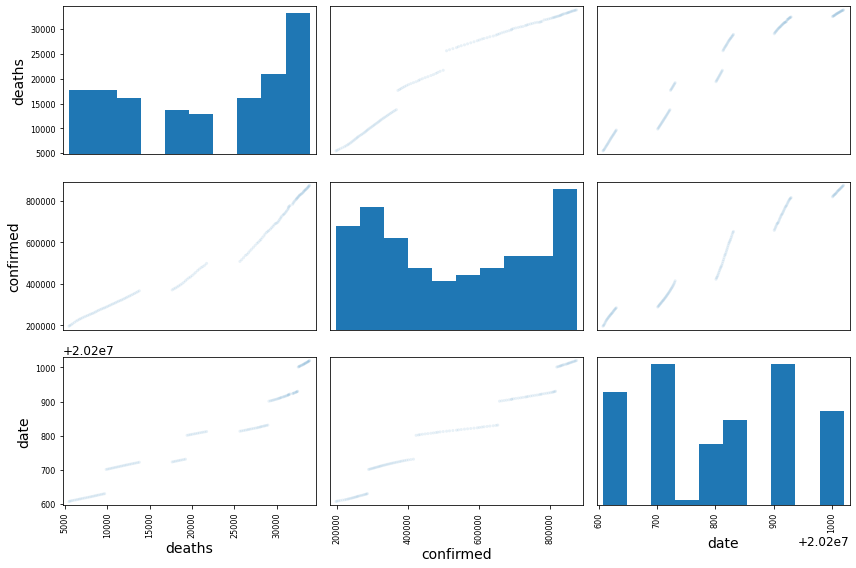

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["deaths", "confirmed", "date"]
scatter_matrix(data_peru[attributes], figsize=(12, 8), alpha=0.1)
save_fig("scatter_matrix_plot")

Se observa de la matriz de dispersión que no hay una secuencialidad de los datos empleando la fecha en formato entero, así que para solucionar este problema usaremos <b>covid_data_sequential</b>, el cual funciona asignando una sequencialidad empezando desde el día número uno.

In [14]:
data_peru['date'] = range(0, len(data_peru))
data_aqp['date'] = range(0, len(data_aqp))
data_peru.head()

,date,total_tests,confirmed,deaths
2020,0,1191956.0,196515.0,5465.0
2046,1,1203985.0,199696.0,5571.0
2072,2,1227691.0,203736.0,5738.0
2098,3,1255756.0,208823.0,5903.0
2124,4,1282478.0,214788.0,6109.0


Volvemos ha realizar una verificación de los datos en la matriz de dispersión y se puede observar una sequencialidad mucho mayor en los datos, ya se observa el comportamiento exponencial que tienen los casos confirmados y las muertes

Saving figure scatter_matrix_plot


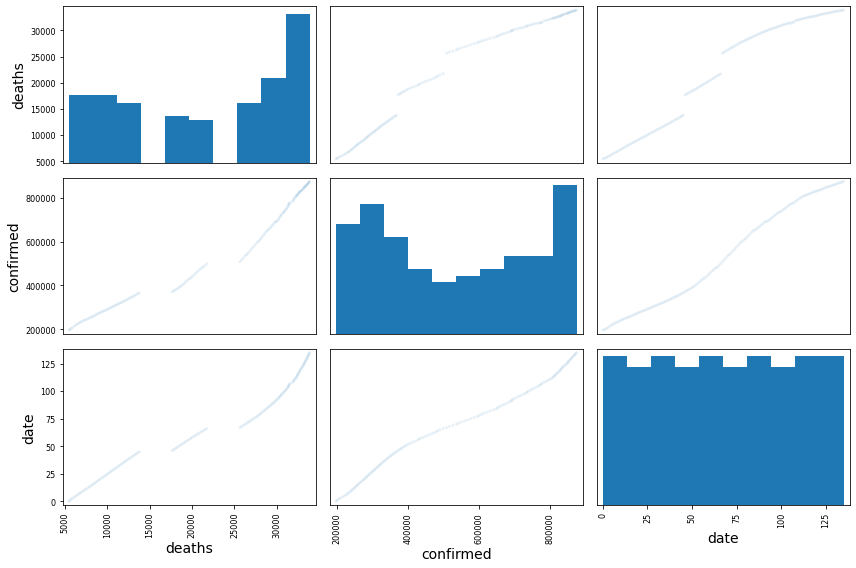

In [52]:
from pandas.plotting import scatter_matrix

attributes = ["deaths", "confirmed", "date"]
scatter_matrix(data_peru[attributes], figsize=(12, 8), alpha=0.1)
save_fig("scatter_matrix_plot")

Saving figure scatter_matrix_plot


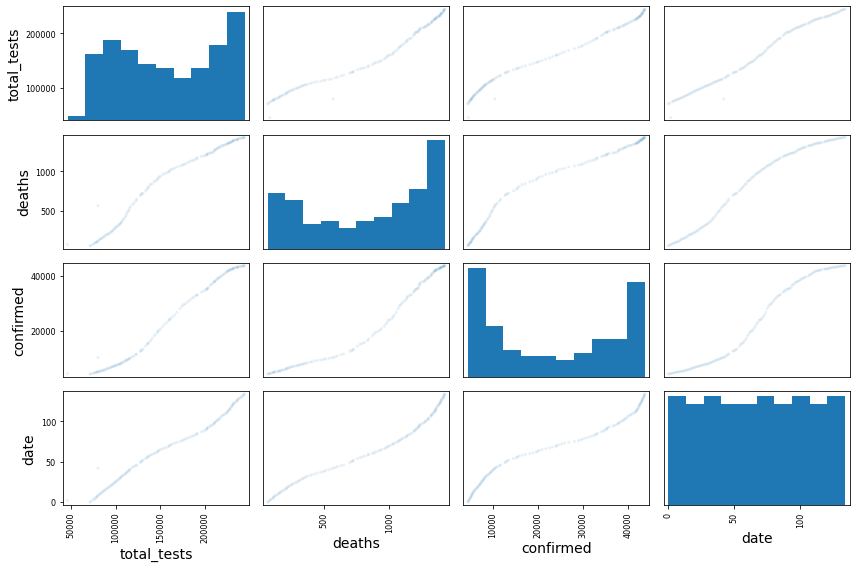

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["total_tests", "deaths", "confirmed", "date"]
scatter_matrix(data_aqp[attributes], figsize=(12, 8), alpha=0.1)
save_fig("scatter_matrix_plot")

### 4. Rellenar los datos de muertes y confirmados faltantes

En los datos de muertes de arequipa mostrados en la celda anterior, existen varios datos nan, cuando estos deberían ser un acumulado del día anterior, es por esto que rellenaremos esos datos con el último acumulado valido. Para esto, reemplazamos los nan de la columna de muertes con el valor 0 y posteriormente, este campo es llenado con el metodo ffill que lo rellena con el inmediato anterior.

In [17]:
#decesos
data_peru['deaths'].fillna(0, inplace=True)
data_aqp['deaths'].fillna(0, inplace=True)

data_peru['deaths'].replace(0, method='ffill', inplace=True)
data_aqp['deaths'].replace(0, method='ffill', inplace=True)

#confirmados
data_peru['confirmed'].fillna(0, inplace=True)
data_aqp['confirmed'].fillna(0, inplace=True)

data_peru['confirmed'].replace(0, method='ffill', inplace=True)
data_aqp['confirmed'].replace(0, method='ffill', inplace=True)

data_aqp.head(50)

,date,total_tests,confirmed,deaths
2024,0,71231.0,4494.0,65.0
2050,1,72346.0,4566.0,71.0
2076,2,46028.0,4620.0,81.0
2102,3,74713.0,4764.0,85.0
2128,4,76082.0,4881.0,95.0
2154,5,77241.0,5002.0,106.0
2180,6,78475.0,5115.0,109.0
2206,7,79171.0,5195.0,115.0
2232,8,79895.0,5280.0,121.0
2258,9,81071.0,5336.0,134.0


### 5. Rellenar los datos de las pruebas totales faltantes

Como se puede observar, las pruebas totales no se encuentran en su totalidad en el dataset, por lo que lo que haremos será generar de manera sintética estos valores. Para ello calcularemos una relación entre los casos confirmados y los días transcurridos.

Calcular la tasa de crecimiento de los tests

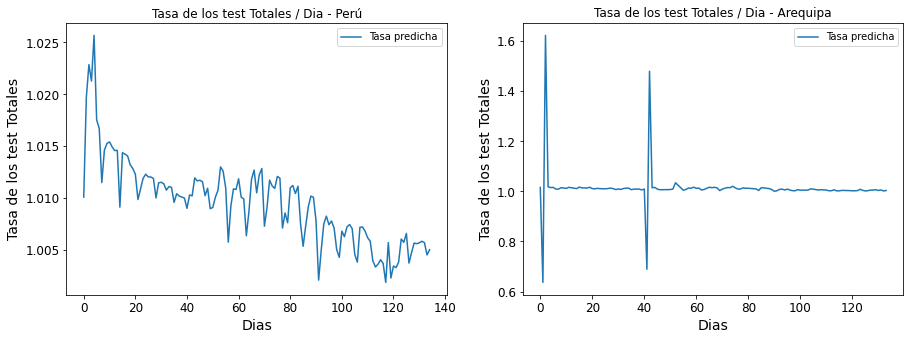

In [18]:
### ==================== Peru
crecimiento_tests_peru = np.ones(len(data_peru) - 1)
for i in range(1,len(data_peru)):
    crecimiento_tests_peru[i-1] = data_peru.iloc[i,1] / data_peru.iloc[i-1,1]

#obtener la tasa de crecimiento para aquellos datos que no cuenten con esta segun los dos datos posteriores
indices = np.where(np.isnan(crecimiento_tests_peru))
for idx in reversed(indices[0]):
    crecimiento_tests_peru[idx] = 2*crecimiento_tests_peru[idx+1] - crecimiento_tests_peru[idx+2]

### ======================= Arequipa
crecimiento_tests_aqp = np.ones(len(data_aqp) - 1)
for i in range(1,len(data_aqp)):
    crecimiento_tests_aqp[i-1] = data_aqp.iloc[i,1] / data_aqp.iloc[i-1,1]

#obtener la tasa de crecimiento para aquellos datos que no cuenten con esta segun los dos datos posteriores
indices = np.where(np.isnan(crecimiento_tests_aqp))
for idx in reversed(indices[0]):
    crecimiento_tests_aqp[idx] = 2*crecimiento_tests_aqp[idx+1] - crecimiento_tests_aqp[idx+2]
#print(crecimiento_tests_aqp)
    

#plotear casos confirmados 
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(crecimiento_tests_peru, label='Tasa predicha')
ax[0].set_title("Tasa de los test Totales / Dia - Perú")
ax[0].set_ylabel('Tasa de los test Totales')
ax[0].set_xlabel('Dias')
ax[0].legend()

ax[1].plot(crecimiento_tests_aqp, label='Tasa predicha')
ax[1].set_title("Tasa de los test Totales / Dia - Arequipa")
ax[1].set_ylabel('Tasa de los test Totales')
ax[1].set_xlabel('Dias')
ax[1].legend()

#np.savetxt("data_peru.csv", data_peru, delimiter=",")
#np.savetxt("data_aqp.csv", data_aqp, delimiter=",")

Observamos un comportamiento ruidoso en el conjunto de datos de Arequipa, esto es debido a que no se encuentran los tests como deberían.
A continuación, crearemos un conjunto de datos nuevo, en el cual adicionamos los tests predichos. Los puntos rojos son datos sinteticos y los datos azules son los datos reales.

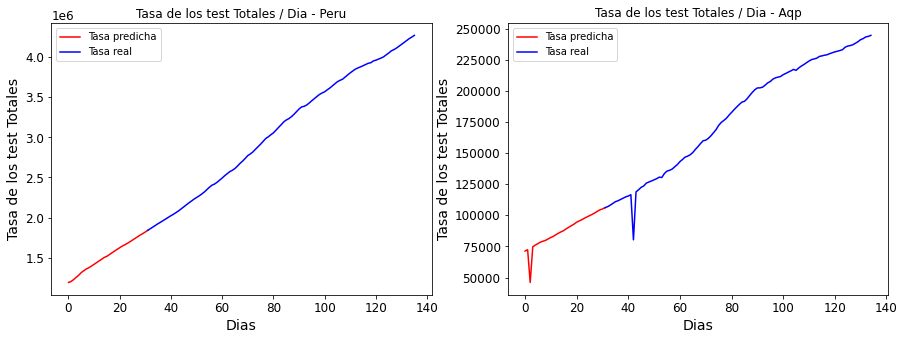

In [19]:
#datos de peru
data_peru_testCovid = data_peru.copy()

indices = np.where(np.isnan(data_peru_testCovid['total_tests']))
for idx in reversed(indices[0]):
    data_peru_testCovid.iloc[idx,1] = data_peru_testCovid.iloc[idx+1,1]  / crecimiento_tests_peru[idx]
    

#datos de aqp
data_aqp_testCovid = data_aqp.copy()
indices = np.where(np.isnan(data_aqp_testCovid['total_tests']))
for idx in reversed(indices[0]):
    data_aqp_testCovid.iloc[idx,1] = data_aqp_testCovid.iloc[idx+1,1]  / crecimiento_tests_aqp[idx]

#plotear casos confirmados 
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(data_peru_testCovid.iloc[:32,0], data_peru_testCovid.iloc[:32,1], c="red", label='Tasa predicha')
ax[0].plot(data_peru_testCovid.iloc[31:,0], data_peru_testCovid.iloc[31:,1], c="blue", label='Tasa real')
ax[0].set_title("Tasa de los test Totales / Dia - Peru")
ax[0].set_ylabel('Tasa de los test Totales')
ax[0].set_xlabel('Dias')
ax[0].legend()

ax[1].plot(data_aqp_testCovid.iloc[:32,0], data_aqp_testCovid.iloc[:32,1], c="red", label='Tasa predicha')
ax[1].plot(data_aqp_testCovid.iloc[31:,0], data_aqp_testCovid.iloc[31:,1], c="blue", label='Tasa real')
ax[1].set_title("Tasa de los test Totales / Dia - Aqp")
ax[1].set_ylabel('Tasa de los test Totales')
ax[1].set_xlabel('Dias')
ax[1].legend()

### 6. Crear Tasas sinteticas de crecimiento de los casos confirmados y de los decesos de covid en Perú y Arequipa

Para tener una predicción que se asemeje a un comportamiento exponencial, emplearemos la correlación entre los datos más cercanos entre sí ya sean de los casos confirmados o de los decesos.

In [20]:
data_peru.head()

,date,total_tests,confirmed,deaths
2020,0,1191956.0,196515.0,5465.0
2046,1,1203985.0,199696.0,5571.0
2072,2,1227691.0,203736.0,5738.0
2098,3,1255756.0,208823.0,5903.0
2124,4,1282478.0,214788.0,6109.0


In [21]:
### ==================== Peru
crecimiento_decesos_peru = np.ones(len(data_peru))
crecimiento_decesos_peru[0] = 1
for i in range(1,len(data_peru)):
    if(data_peru.iloc[i-1,3]):
        crecimiento_decesos_peru[i] = data_peru.iloc[i,3] / data_peru.iloc[i-1,3]
data_peru['tasa_deaths'] = crecimiento_decesos_peru

crecimiento_confirmados_peru = np.ones(len(data_peru))
crecimiento_confirmados_peru[0] = 1
for i in range(1,len(data_peru)):
    if(data_peru.iloc[i-1,2]):
        crecimiento_confirmados_peru[i] = data_peru.iloc[i,2] / data_peru.iloc[i-1,2]
data_peru['tasa_confirmed'] = crecimiento_confirmados_peru


### ======================= Arequipa
crecimiento_decesos_aqp = np.ones(len(data_aqp))
crecimiento_decesos_aqp[0] = 1
for i in range(1,len(data_aqp)):
    if(data_aqp.iloc[i-1,3]):
        crecimiento_decesos_aqp[i] = data_aqp.iloc[i,3] / data_aqp.iloc[i-1,3]
data_aqp['tasa_deaths'] = crecimiento_decesos_aqp

crecimiento_confirmados_aqp = np.ones(len(data_aqp))
crecimiento_confirmados_aqp[0] = 1
for i in range(1,len(data_aqp)):
    if(data_aqp.iloc[i-1,2]):
        crecimiento_confirmados_aqp[i] = data_aqp.iloc[i,2] / data_aqp.iloc[i-1,2]
data_aqp['tasa_confirmed'] = crecimiento_confirmados_aqp

Reordenar los datos de tal forma que dejen las columnas a predecir para el final yquitar los tests para estos datos

In [22]:
columns_titles = ["date", "tasa_deaths", "tasa_confirmed", "confirmed","deaths"]
data_peru = data_peru.reindex(columns=columns_titles)
data_aqp = data_aqp.reindex(columns=columns_titles)

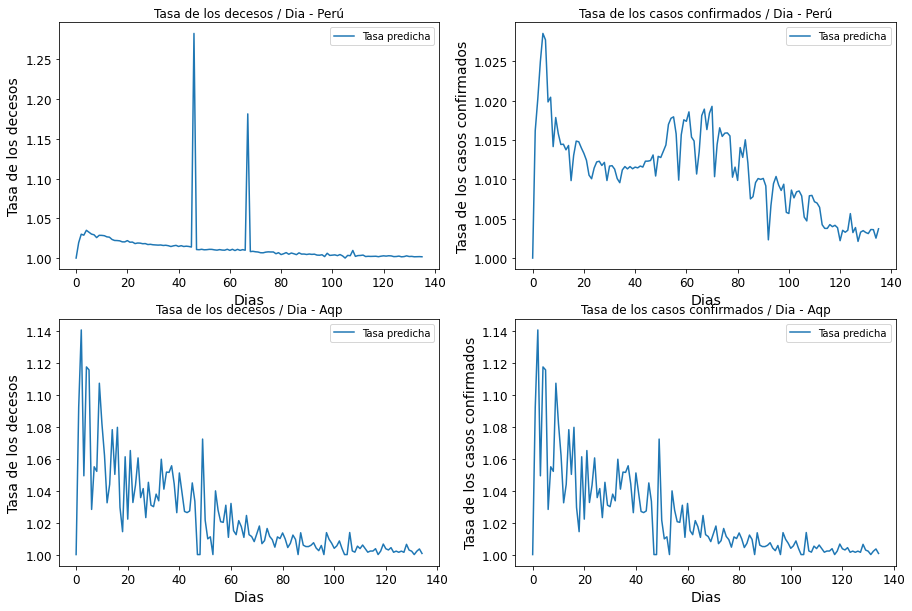

In [23]:
#plotear casos confirmados 
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0][0].plot(crecimiento_decesos_peru, label='Tasa predicha')
ax[0][0].set_title("Tasa de los decesos / Dia - Perú")
ax[0][0].set_ylabel('Tasa de los decesos')
ax[0][0].set_xlabel('Dias')
ax[0][0].legend()

ax[0][1].plot(crecimiento_confirmados_peru, label='Tasa predicha')
ax[0][1].set_title("Tasa de los casos confirmados / Dia - Perú")
ax[0][1].set_ylabel('Tasa de los casos confirmados')
ax[0][1].set_xlabel('Dias')
ax[0][1].legend()

ax[1][0].plot(crecimiento_decesos_aqp, label='Tasa predicha')
ax[1][0].set_title("Tasa de los decesos / Dia - Aqp")
ax[1][0].set_ylabel('Tasa de los decesos')
ax[1][0].set_xlabel('Dias')
ax[1][0].legend()

ax[1][1].plot(crecimiento_decesos_aqp, label='Tasa predicha')
ax[1][1].set_title("Tasa de los casos confirmados / Dia - Aqp")
ax[1][1].set_ylabel('Tasa de los casos confirmados')
ax[1][1].set_xlabel('Dias')
ax[1][1].legend()

In [24]:
data_peru.head()

,date,tasa_deaths,tasa_confirmed,confirmed,deaths
2020,0,1.000000,1.000000,196515.0,5465.0
2046,1,1.019396,1.016187,199696.0,5571.0
2072,2,1.029977,1.020231,203736.0,5738.0
2098,3,1.028756,1.024969,208823.0,5903.0
2124,4,1.034898,1.028565,214788.0,6109.0


# Preparar los datos para la regresión multivariada

Para realizar este proceso seguimos los siguientes pasos:
<ol>
    <li>Normalizar los datos</li>
    <li>Dividir los datos en conjuntos de entrenamiento y prueba</li>
    <li>Dividir los datos en conjunto de datos de casos confirmados y conjunto de datos de decesos y realizar el resto de pasos</li>
</ol>

### 1. Normalizar los datos

In [25]:
def Normalizar_Datos( data ):
    mean = np.nanmean(data, axis=0)
    standard = np.nanstd(data, axis=0)
    #print (mean, standard)
    data = (data - mean)/standard
    return data, mean, standard

In [26]:
data_peru2, mean_peru, standard_peru = Normalizar_Datos(data_peru)
data_aqp2, mean_aqp, standard_aqp = Normalizar_Datos(data_aqp)
data_peru_testCovid2, mean_peru_testCovid, standard_peru_testCovid = Normalizar_Datos(data_peru_testCovid)
data_aqp_testCovid2, mean_aqp_testCovid, standard_aqp_testCovid = Normalizar_Datos(data_aqp_testCovid)

### 2. Dividir los datos en conjuntos de entrenamiento y prueba

El conjunto de datos de entrenamiento fue generado usando un 80% del conjunto de datos total (equivalente al ranfo entre  <b>13/03/2020</b> y <b>29/08/2020</b>), y se mantuvo la secuencialidad por lo que no se realizó ningun intercambio de posiciones (shuffle=False).

In [27]:
from sklearn.model_selection import train_test_split

train_peru, test_peru = train_test_split(data_peru2, test_size=0.2, shuffle=False)
train_aqp, test_aqp = train_test_split(data_aqp2, test_size=0.2, shuffle=False)
train_peru_testCovid, test_peru_testCovid = train_test_split(data_peru_testCovid2, test_size=0.2, shuffle=False)
train_aqp_testCovid, test_aqp_testCovid = train_test_split(data_aqp_testCovid2, test_size=0.2, shuffle=False)

Función usada para preparar los datos, recibe los datos de entrenamiento y prueba (con data frames que incluyen los casos confirmados y los decesos) para asi ser divididos por confirmado y deceso, luego divididos por aquellos datos que seran usados como entrada y como salida y finalmente, se le agregarán unos a los datos de entrada (a manera de bias) para que estén listos para el entrenamiento.

In [28]:
def preparar_datos(train_decesos_data, test_decesos_data, train_confirmados_data, test_confirmados_data):
    #======Dividir el input del output
    #decesos
    train_decesos_data_X = train_decesos_data.iloc[:,0:-1]
    train_decesos_data_y = train_decesos_data.iloc[:,-1:]
    test_decesos_data_X = test_decesos_data.iloc[:,0:-1]
    test_decesos_data_y = test_decesos_data.iloc[:,-1:]
    #confirmados
    train_confirmados_data_X = train_confirmados_data.iloc[:,0:-1]
    train_confirmados_data_y = train_confirmados_data.iloc[:,-1:]
    test_confirmados_data_X = test_confirmados_data.iloc[:,0:-1]
    test_confirmados_data_y = test_confirmados_data.iloc[:,-1:]

    #======Agregar una columna de unos al conjunto de entrenamiento y al conjunto de prueba
    #decesos
    num_elements_decesos_train = len(train_decesos_data_y)
    num_elements_decesos_test = len(test_decesos_data_y)

    train_decesos_data_X = np.concatenate((np.ones([num_elements_decesos_train, 1]), train_decesos_data_X), axis=1)
    test_decesos_data_X = np.concatenate((np.ones([num_elements_decesos_test, 1]), test_decesos_data_X), axis=1)

    #confirmados
    num_elements_confrimados_train = len(train_confirmados_data_y)
    num_elements_confrimados_test = len(test_confirmados_data_y)

    train_confirmados_data_X = np.concatenate((np.ones([num_elements_confrimados_train, 1]), train_confirmados_data_X), axis=1)
    test_confirmados_data_X = np.concatenate((np.ones([num_elements_confrimados_test, 1]), test_confirmados_data_X), axis=1)

    return train_decesos_data_X, train_decesos_data_y, test_decesos_data_X, test_decesos_data_y, train_confirmados_data_X, train_confirmados_data_y, test_confirmados_data_X, test_confirmados_data_y

### 3. Dividir los datos en conjunto de datos de casos confirmados y conjunto de datos de decesos y realizar el resto de pasos

Para hacer todo el proceso seguimos los siguientes pasos en cada conjunto de datos:
    <ol>
    <li>Dividir los conjuntos de casos confirmados de los casos de decesos</li>
    <li>Dividir el input del output y los casos confirmados de los decesos</li>
    <li>Dividir los datos en conjunto de datos de casos confirmados y conjunto de datos de decesos y realizar el resto de pasosAgregar una columna de unos al conjunto de entrenamiento y al conjunto de prueba</li>
</ol>

Datos de Perú

In [29]:
#======Dividir los conjuntos de casos confirmados de los casos de decesos
train_confirmados_peru = train_peru.copy()
test_confirmados_peru = test_peru.copy()
train_decesos_peru = train_peru.copy()
test_decesos_peru = test_peru.copy()

#decesos
columns_titles = ["date", "tasa_deaths","deaths"]
train_decesos_peru = train_decesos_peru.reindex(columns=columns_titles)
test_decesos_peru = test_decesos_peru.reindex(columns=columns_titles)

#confirmados
columns_titles = ["date", "tasa_confirmed", "confirmed"]
train_confirmados_peru = train_confirmados_peru.reindex(columns=columns_titles)
test_confirmados_peru = test_confirmados_peru.reindex(columns=columns_titles)

train_decesos_peru_X, train_decesos_peru_y, test_decesos_peru_X, test_decesos_peru_y, train_confirmados_peru_X, train_confirmados_peru_y, test_confirmados_peru_X, test_confirmados_peru_y = preparar_datos(train_decesos_peru, test_decesos_peru, train_confirmados_peru, test_confirmados_peru)

Datos de Arequipa

In [30]:
#======Dividir los conjuntos de casos confirmados de los casos de decesos
train_confirmados_aqp = train_aqp.copy()
test_confirmados_aqp = test_aqp.copy()
train_decesos_aqp = train_aqp.copy()
test_decesos_aqp = test_aqp.copy()

#decesos
columns_titles = ["date", "tasa_deaths","deaths"]
train_decesos_aqp = train_decesos_aqp.reindex(columns=columns_titles)
test_decesos_aqp = test_decesos_aqp.reindex(columns=columns_titles)

#confirmados
columns_titles = ["date", "tasa_confirmed", "confirmed"]
train_confirmados_aqp = train_confirmados_aqp.reindex(columns=columns_titles)
test_confirmados_aqp = test_confirmados_aqp.reindex(columns=columns_titles)

train_decesos_aqp_X, train_decesos_aqp_y, test_decesos_aqp_X, test_decesos_aqp_y, train_confirmados_aqp_X, train_confirmados_aqp_y, test_confirmados_aqp_X, test_confirmados_aqp_y = preparar_datos(train_decesos_aqp, test_decesos_aqp, train_confirmados_aqp, test_confirmados_aqp)

Datos de Peru con tests de covid

In [31]:
#======Dividir los conjuntos de casos confirmados de los casos de decesos
train_confirmados_testCovid = train_peru_testCovid.copy()
test_confirmados_testCovid = test_peru_testCovid.copy()
train_decesos_testCovid = train_peru_testCovid.copy()
test_decesos_testCovid = test_peru_testCovid.copy()

#decesos
train_decesos_testCovid = train_decesos_testCovid.drop(['confirmed'], axis=1)
test_decesos_testCovid = test_decesos_testCovid.drop(['confirmed'], axis=1)
#confirmados
train_confirmados_testCovid = train_confirmados_testCovid.drop(['deaths'], axis=1)
test_confirmados_testCovid = test_confirmados_testCovid.drop(['deaths'], axis=1)

train_decesos_peru_testCovid_X, train_decesos_peru_testCovid_y, test_decesos_peru_testCovid_X, test_decesos_peru_testCovid_y, train_confirmados_peru_testCovid_X, train_confirmados_peru_testCovid_y, test_confirmados_peru_testCovid_X, test_confirmados_peru_testCovid_y = preparar_datos(train_decesos_testCovid, test_decesos_testCovid, train_confirmados_testCovid, test_confirmados_testCovid)

Datos de Arequipa con tests de covid

In [32]:
#======Dividir los conjuntos de casos confirmados de los casos de decesos
train_confirmados_testCovid_aqp = train_aqp_testCovid.copy()
test_confirmados_testCovid_aqp = test_aqp_testCovid.copy()
train_decesos_testCovid_aqp = train_aqp_testCovid.copy()
test_decesos_testCovid_aqp = test_aqp_testCovid.copy()

#decesos
train_decesos_testCovid_aqp = train_decesos_testCovid_aqp.drop(['confirmed'], axis=1)
test_decesos_testCovid_aqp = test_decesos_testCovid_aqp.drop(['confirmed'], axis=1)
#confirmados
train_confirmados_testCovid_aqp = train_confirmados_testCovid_aqp.drop(['deaths'], axis=1)
test_confirmados_testCovid_aqp = test_confirmados_testCovid_aqp.drop(['deaths'], axis=1)

train_decesos_aqp_testCovid_X, train_decesos_aqp_testCovid_y, test_decesos_aqp_testCovid_X, test_decesos_aqp_testCovid_y, train_confirmados_aqp_testCovid_X, train_confirmados_aqp_testCovid_y, test_confirmados_aqp_testCovid_X, test_confirmados_aqp_testCovid_y = preparar_datos(train_decesos_testCovid_aqp, test_decesos_testCovid_aqp, train_confirmados_testCovid_aqp, test_confirmados_testCovid_aqp)

# Modelo de regresor lineal

Funciones que forman parte del regresor lineal

In [33]:
#importamos los errores que emplearemos
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calcular_errores(y, pred):
    print ('r2 score', r2_score(y, pred))
    print ('MSE', mean_squared_error(y, pred))
    print ('RMSE', sqrt(mean_squared_error(y, pred)))
    
def calcular_Costo(X, Y, Theta):
    m = len(X)
    cost = np.sum((X.dot(Theta.T) - Y)**2) / (2 * m)
    return cost

def predict(X, theta):
    return X.dot(theta.T)

def gradiente_Descendiente(X, Y, theta, iteraciones, tasa):
    costos = [0]*iteraciones
    m = len(X)
    for itr in range(iteraciones):
        h = predict(X, theta)
        dif = h - Y
        derivada = (X.T).dot(dif) / m
        theta = theta - (tasa * derivada).T
        
        costos[itr] = calcular_Costo(X, Y, theta)
    return theta, costos

## Probando los datos en el modelo de regresor lineal
Realizamos las siguiente pruebas:
<ul>
    <li>Prueba número 1: Entrenar y testear con el conjunto de datos de Perú</li>
    <li>Prueba número 2: Entrenar y validar con el conjunto de datos de Arequipa</li>
    <li>Prueba número 3: Entrenar y testear con el conjunto de datos de Perú empleando los test de covid totales</li>
    <li>Prueba número 4: Entrenar y testear con el conjunto de datos de Arequipa empleando los test de covid totales</li>
</ul>

### Prueba número 1: Entrenar y testear con el conjunto de datos de Perú

Ejecutar el gradiente descendiente para el <b>conjunto de datos de Perú</b>

Entrenamiento

In [34]:
#train_decesos_peru_X, train_decesos_peru_y, test_decesos_peru_X, test_decesos_peru_y, 
#train_confirmados_peru_X, train_confirmados_peru_y, test_confirmados_peru_X, test_confirmados_peru_y 

n_features = train_confirmados_peru_X.shape[1]
theta_confirmados_peru = np.zeros(n_features)[np.newaxis]

theta_confirmados_peru, costos_confirmados_peru = gradiente_Descendiente(
    train_confirmados_peru_X, train_confirmados_peru_y, theta_confirmados_peru, 1000, 0.1
)

[[ 0.00526042  0.99366245 -0.01506634]]


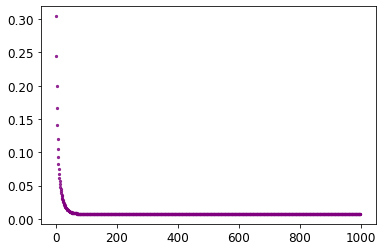

In [35]:
print(theta_confirmados_peru)
plt.scatter(np.arange(len(costos_confirmados_peru)), costos_confirmados_peru, alpha=0.8, c="purple", s=5)

In [36]:
n_features = train_decesos_peru_X.shape[1]
theta_decesos_peru = np.zeros(n_features)[np.newaxis]

theta_decesos_peru, costos_decesos_peru = gradiente_Descendiente(
    train_decesos_peru_X, train_decesos_peru_y, theta_decesos_peru, 1000, 0.1
)

[[0.11098248 1.1435665  0.02063335]]


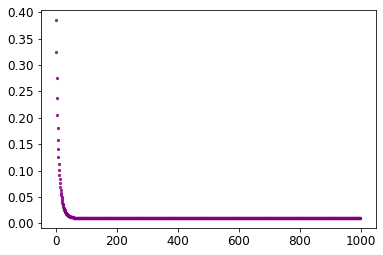

In [37]:
print(theta_decesos_peru)
plt.scatter(np.arange(len(costos_decesos_peru)), costos_decesos_peru, alpha=0.8, c="purple", s=5)

Validación

In [38]:
#predecir casos confirmados
predict_confirmados_peru = predict( test_confirmados_peru_X ,theta_confirmados_peru)

In [39]:
#predecir decesos
predict_decesos_peru = predict( test_decesos_peru_X ,theta_decesos_peru)

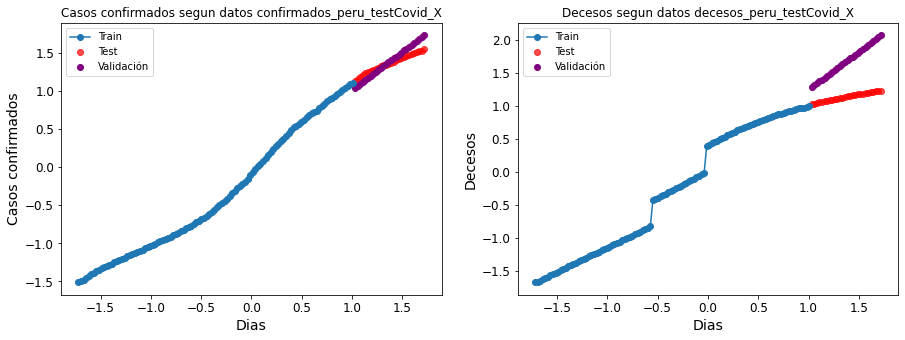

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#plotear casos confirmados 
ax[0].scatter(test_confirmados_peru_X[:,1], test_confirmados_peru_y, alpha=0.7, c="red", label="Test")
ax[0].scatter(test_confirmados_peru_X[:,1], predict_confirmados_peru, alpha=1.0, c="purple", label="Validación")
ax[0].plot(train_confirmados_peru_X[:,1], train_confirmados_peru_y, "-o", label="Train")
ax[0].set_title("Casos confirmados segun datos confirmados_peru_testCovid_X")
ax[0].set_ylabel('Casos confirmados')
ax[0].set_xlabel('Dias')
ax[0].legend()

#plotear decesos 
ax[1].scatter(test_decesos_peru_X[:,1], test_decesos_peru_y, alpha=0.7, c="red", label="Test")
ax[1].scatter(test_decesos_peru_X[:,1], predict_decesos_peru, alpha=1.0, c="purple", label="Validación")
ax[1].plot(train_decesos_peru_X[:,1], train_decesos_peru_y, "-o", label="Train")
ax[1].set_title("Decesos segun datos decesos_peru_testCovid_X")
ax[1].set_ylabel('Decesos')
ax[1].set_xlabel('Dias')
ax[1].legend()

In [41]:
#Calcular los errores de validación de los casos confirmados
calcular_errores(test_confirmados_peru_y, predict_confirmados_peru)

r2 score 0.324973452673618
MSE 0.00914995336109427
RMSE 0.09565538856276874


In [42]:
#Calcular los errores de validación de los decesos
calcular_errores(test_decesos_peru_y, predict_decesos_peru)

r2 score -83.46127643290433
MSE 0.32061404218395795
RMSE 0.5662279065746918


### Prueba número 2: Entrenar y validar con el conjunto de datos de Arequipa

Ejecutar el gradiente descendiente para el <b>conjunto de datos de Arequipa</b>

Entrenamiento

In [43]:
#train_decesos_peru_X, train_decesos_peru_y, test_decesos_peru_X, test_decesos_peru_y, 
#train_confirmados_peru_X, train_confirmados_peru_y, test_confirmados_peru_X, test_confirmados_peru_y 

n_features = train_confirmados_aqp_X.shape[1]
theta_confirmados_aqp = np.zeros(n_features)[np.newaxis]

theta_confirmados_aqp, costos_confirmados_aqp = gradiente_Descendiente(
    train_confirmados_aqp_X, train_confirmados_aqp_y, theta_confirmados_aqp, 1000, 0.1
)

[[ 0.03774247  1.00680786 -0.07227619]]


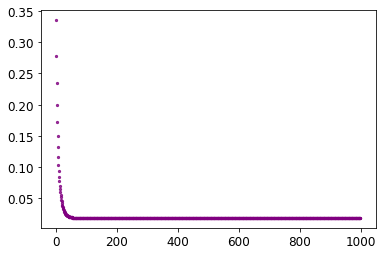

In [44]:
print(theta_confirmados_aqp)
plt.scatter(np.arange(len(costos_confirmados_aqp)), costos_confirmados_aqp, alpha=0.8, c="purple", s=5)

In [45]:
n_features = train_decesos_aqp_X.shape[1]
theta_decesos_aqp = np.zeros(n_features)[np.newaxis]

theta_decesos_aqp, costos_decesos_aqp = gradiente_Descendiente(
    train_decesos_aqp_X, train_decesos_aqp_y, theta_decesos_aqp, 1000, 0.1
)

[[ 0.1022146   1.12394834 -0.00897158]]


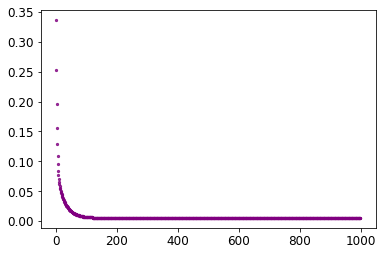

In [46]:
print(theta_decesos_aqp)
plt.scatter(np.arange(len(costos_decesos_aqp)), costos_decesos_aqp, alpha=0.8, c="purple", s=5)

Validación

In [47]:
#predecir casos confirmados
predict_confirmados_aqp = predict( test_confirmados_aqp_X ,theta_confirmados_aqp)

In [48]:
#predecir decesos
predict_decesos_aqp = predict( test_decesos_aqp_X ,theta_decesos_aqp)

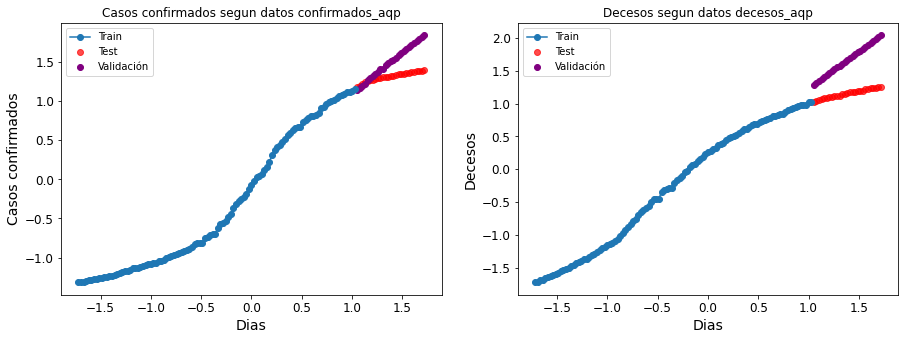

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#plotear casos confirmados 
ax[0].scatter(test_confirmados_aqp_X[:,1], test_confirmados_aqp_y, alpha=0.7, c="red", label="Test")
ax[0].scatter(test_confirmados_aqp_X[:,1], predict_confirmados_aqp, alpha=1.0, c="purple", label="Validación")
ax[0].plot(train_confirmados_aqp_X[:,1], train_confirmados_aqp_y, "-o", label="Train")
ax[0].set_title("Casos confirmados segun datos confirmados_aqp")
ax[0].set_ylabel('Casos confirmados')
ax[0].set_xlabel('Dias')
ax[0].legend()

#plotear decesos 
ax[1].scatter(test_decesos_aqp_X[:,1], test_decesos_aqp_y, alpha=0.7, c="red", label="Test")
ax[1].scatter(test_decesos_aqp_X[:,1], predict_decesos_aqp, alpha=1.0, c="purple", label="Validación")
ax[1].plot(train_decesos_aqp_X[:,1], train_decesos_aqp_y, "-o", label="Train")
ax[1].set_title("Decesos segun datos decesos_aqp")
ax[1].set_ylabel('Decesos')
ax[1].set_xlabel('Dias')
ax[1].legend()

In [50]:
#Calcular los errores de validación de los casos confirmados
calcular_errores(test_confirmados_aqp_y, predict_confirmados_aqp)

r2 score -16.142243290178165
MSE 0.05869393827718544
RMSE 0.2422683187649294


In [51]:
#Calcular los errores de validación de los decesos
calcular_errores(test_decesos_aqp_y, predict_decesos_aqp)

r2 score -64.33547867076793
MSE 0.2864711489058049
RMSE 0.5352299962687115


### Prueba número 3: Entrenar y testear con el conjunto de datos de Perú empleando los test de covid totales

Ejecutar el gradiente descendiente para el <b>conjunto de datos de Perú con los tests de covid totales</b>

Entrenamiento

In [53]:
n_features = train_confirmados_peru_testCovid_X.shape[1]
theta_confirmados_peru_testCovid = np.zeros(n_features)[np.newaxis]

theta_confirmados_peru_testCovid, costos_confirmados_peru_testCovid = gradiente_Descendiente(
    train_confirmados_peru_testCovid_X, train_confirmados_peru_testCovid_y, theta_confirmados_peru_testCovid, 1000, 0.1
)


[[-0.00760203  0.24289621  0.74429408]]


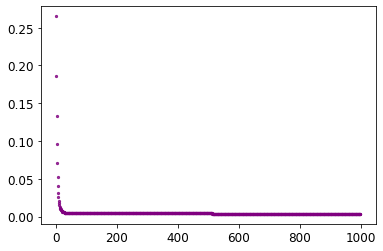

In [54]:
print(theta_confirmados_peru_testCovid)
plt.scatter(np.arange(len(costos_confirmados_peru_testCovid)), costos_confirmados_peru_testCovid, alpha=0.8, c="purple", s=5)

In [55]:
n_features = train_decesos_peru_testCovid_X.shape[1]
theta_decesos_peru_testCovid = np.zeros(n_features)[np.newaxis]

theta_decesos_peru_testCovid, costos_decesos_peru_testCovid = gradiente_Descendiente(
    train_decesos_peru_testCovid_X, train_decesos_peru_testCovid_y, theta_decesos_peru_testCovid, 1000, 0.1
)

[[0.10045481 0.55587781 0.56814473]]


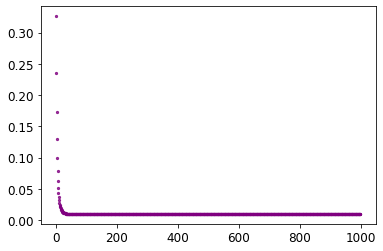

In [56]:
print(theta_decesos_peru_testCovid)
plt.scatter(np.arange(len(costos_decesos_peru_testCovid)), costos_decesos_peru_testCovid, alpha=0.8, c="purple", s=5)

Validación

In [57]:
#predecir casos confirmados
predict_confirmados_peru_testCovid = predict( test_confirmados_peru_testCovid_X ,theta_confirmados_peru_testCovid)

In [58]:
#predecir decesos
predict_decesos_peru_testCovid = predict( test_decesos_peru_testCovid_X ,theta_decesos_peru_testCovid)

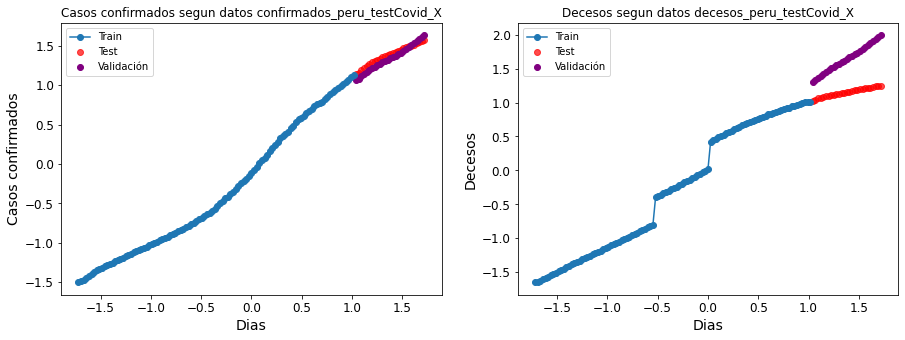

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#plotear casos confirmados 
ax[0].scatter(test_confirmados_peru_testCovid_X[:,1], test_confirmados_peru_testCovid_y, alpha=0.7, c="red", label="Test")
ax[0].scatter(test_confirmados_peru_testCovid_X[:,1], predict_confirmados_peru_testCovid, alpha=1.0, c="purple", label="Validación")
ax[0].plot(train_confirmados_peru_testCovid_X[:,1], train_confirmados_peru_testCovid_y, "-o", label="Train")
ax[0].set_title("Casos confirmados segun datos confirmados_peru_testCovid_X")
ax[0].set_ylabel('Casos confirmados')
ax[0].set_xlabel('Dias')
ax[0].legend()

#plotear decesos 
ax[1].scatter(test_decesos_peru_testCovid_X[:,1], test_decesos_peru_testCovid_y, alpha=0.7, c="red", label="Test")
ax[1].scatter(test_decesos_peru_testCovid_X[:,1], predict_decesos_peru_testCovid, alpha=1.0, c="purple", label="Validación")
ax[1].plot(train_decesos_peru_testCovid_X[:,1], train_decesos_peru_testCovid_y, "-o", label="Train")
ax[1].set_title("Decesos segun datos decesos_peru_testCovid_X")
ax[1].set_ylabel('Decesos')
ax[1].set_xlabel('Dias')
ax[1].legend()

In [60]:
#Calcular los errores de validación de los casos confirmados
print ('r2 score', r2_score(test_confirmados_peru_testCovid_y, predict_confirmados_peru_testCovid))
print ('MSE', mean_squared_error(test_confirmados_peru_testCovid_y, predict_confirmados_peru_testCovid))
print ('RMSE', sqrt(mean_squared_error(test_confirmados_peru_testCovid_y, predict_confirmados_peru_testCovid)))

r2 score 0.7827303004382233
MSE 0.0032712380611650193
RMSE 0.057194738054868466


In [61]:
#Calcular los errores de validación de los decesos
print ('r2 score', r2_score(test_decesos_peru_testCovid_y, predict_decesos_peru_testCovid))
print ('MSE', mean_squared_error(test_decesos_peru_testCovid_y, predict_decesos_peru_testCovid))
print ('RMSE', sqrt(mean_squared_error(test_decesos_peru_testCovid_y, predict_decesos_peru_testCovid)))

r2 score -61.60119002359784
MSE 0.2629715501640366
RMSE 0.5128075176555397


Se puede observar que el método del regresor lineal con este segundo conjunto de datos tiene un mejor performance, por lo que emplearemos este para la predicción de las muertes y casos confirmados de Covid en el Perú.

### Prueba número 4: Entrenar y testear con el conjunto de datos de Arequipa empleando los test de covid totales

Ejecutar el gradiente descendiente para el <b>conjunto de datos de Arequipa con los tests de covid totales</b>

Entrenamiento

In [62]:
n_features = train_confirmados_aqp_testCovid_X.shape[1]
theta_confirmados_aqp_testCovid = np.zeros(n_features)[np.newaxis]

theta_confirmados_aqp_testCovid, costos_confirmados_aqp_testCovid = gradiente_Descendiente(
    train_confirmados_aqp_testCovid_X, train_confirmados_aqp_testCovid_y, theta_confirmados_aqp_testCovid, 1000, 0.1
)


[[-0.00271152  0.11134231  0.87697409]]


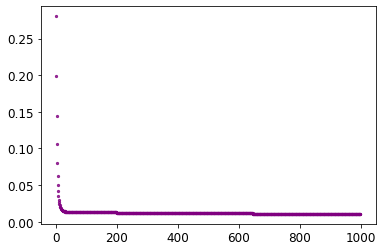

In [63]:
print(theta_confirmados_aqp_testCovid)
plt.scatter(np.arange(len(costos_confirmados_aqp_testCovid)), costos_confirmados_aqp_testCovid, alpha=0.8, c="purple", s=5)

In [64]:
n_features = train_decesos_aqp_testCovid_X.shape[1]
theta_decesos_aqp_testCovid = np.zeros(n_features)[np.newaxis]

theta_decesos_aqp_testCovid, costos_decesos_aqp_testCovid = gradiente_Descendiente(
    train_decesos_aqp_testCovid_X, train_decesos_aqp_testCovid_y, theta_decesos_aqp_testCovid, 1000, 0.1
)

[[0.09585507 0.97740265 0.14399419]]


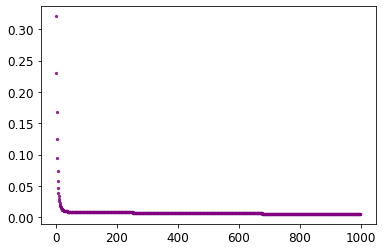

In [65]:
print(theta_decesos_aqp_testCovid)
plt.scatter(np.arange(len(costos_decesos_aqp_testCovid)), costos_decesos_aqp_testCovid, alpha=0.8, c="purple", s=5)

Validación

In [66]:
#predecir casos confirmados
predict_confirmados_aqp_testCovid = predict( test_confirmados_aqp_testCovid_X ,theta_confirmados_aqp_testCovid)

In [67]:
#predecir decesos
predict_decesos_aqp_testCovid = predict( test_decesos_aqp_testCovid_X ,theta_decesos_aqp_testCovid)

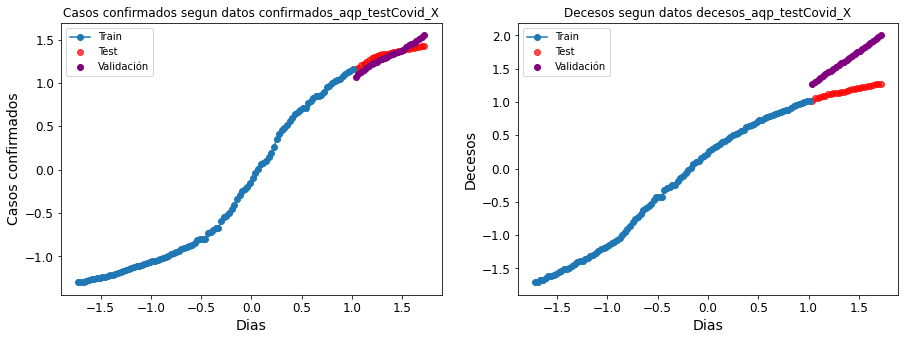

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#plotear casos confirmados 
ax[0].scatter(test_confirmados_aqp_testCovid_X[:,1], test_confirmados_aqp_testCovid_y, alpha=0.7, c="red", label="Test")
ax[0].scatter(test_confirmados_aqp_testCovid_X[:,1], predict_confirmados_aqp_testCovid, alpha=1.0, c="purple", label="Validación")
ax[0].plot(train_confirmados_aqp_testCovid_X[:,1], train_confirmados_aqp_testCovid_y, "-o", label="Train")
ax[0].set_title("Casos confirmados segun datos confirmados_aqp_testCovid_X")
ax[0].set_ylabel('Casos confirmados')
ax[0].set_xlabel('Dias')
ax[0].legend()

#plotear decesos 
ax[1].scatter(test_decesos_aqp_testCovid_X[:,1], test_decesos_aqp_testCovid_y, alpha=0.7, c="red", label="Test")
ax[1].scatter(test_decesos_aqp_testCovid_X[:,1], predict_decesos_aqp_testCovid, alpha=1.0, c="purple", label="Validación")
ax[1].plot(train_decesos_aqp_testCovid_X[:,1], train_decesos_aqp_testCovid_y, "-o", label="Train")
ax[1].set_title("Decesos segun datos decesos_aqp_testCovid_X")
ax[1].set_ylabel('Decesos')
ax[1].set_xlabel('Dias')
ax[1].legend()

In [69]:
#Calcular los errores de validación de los casos confirmados
calcular_errores(test_confirmados_aqp_testCovid_y, predict_confirmados_aqp_testCovid)

r2 score 0.32603827183912515
MSE 0.003872212095873341
RMSE 0.06222710097596819


In [70]:
#Calcular los errores de validación de los casos confirmados
calcular_errores(test_decesos_aqp_testCovid_y, predict_decesos_aqp_testCovid)

r2 score -46.02072474407087
MSE 0.24135799875041009
RMSE 0.49128199514170073


All igual que en el anterior caso, se puede observar que el método del regresor lineal con este segundo conjunto de datos de Arequipa tiene un mejor performance por sobre el conjunto de datos sin los tests positivos, por lo que emplearemos este para la predicción de las muertes y casos confirmados de Covid en Arequipa.

# Predicción

Para realizar la predicción realizaremos los siguientes pasos:
<ol>
    <li>Generaremos el conjunto de datos como entrada para el predictor</li>
    <li>Predecimos los datos y ploteamos</li>
    <li>Recuperar el valor real de la predicción</li>
</ol>

### 1. Generaremos el conjunto de datos como entrada para el predictor

Calcular los proximos 10 dias

In [119]:
#ultimo dia es el 17 de octubre del 2020
octubre_17 = data_peru_testCovid.iloc[-1,0]
octubre_19 = octubre_17 + 2
octubre_29 = octubre_19 + 10

new_dates = np.array(range(octubre_19, octubre_29))
size_future_data = len(new_dates)

Calcular el promedio de la tasa de crecimiento de los tests, de tal manera que esa tasa sea usada para predecir futuros tests.

<b>Datos para predecir en Perú</b>

In [120]:
future_crecimiento_peru = np.mean(crecimiento_tests_peru[-10])
future_crecimiento_peru

1.00383468695384

In [121]:
future_tests_peru = np.ones(size_future_data)

future_tests_peru[0] = data_peru_testCovid.iloc[-1,1] * future_crecimiento_peru
for i in range(1, size_future_data):
    future_tests_peru[i] = future_tests_peru[i-1] * future_crecimiento_peru  
print(future_tests_peru)

[4222501.11599671 4238693.0859388  4254947.14701678 4271263.53733072
 4287642.49589374 4304084.26263547 4320589.07840563 4337157.18497749
 4353788.82505148 4370484.24225868]


In [122]:
future_data_peru = pd.DataFrame({'date': new_dates, 'total_tests': future_tests_peru})

In [123]:
#normalizar
mean = mean_peru_testCovid[:-2]
standard = standard_peru_testCovid[:-2]
future_data_peru = (future_data_peru - mean)/standard

In [124]:
#agregar unos
future_data_peru = np.concatenate((np.ones([size_future_data, 1]), future_data_peru), axis=1)

<b>Datos para predecir en Arequipa</b>

In [125]:
future_crecimiento_aqp = np.mean(crecimiento_tests_aqp[-10])
future_crecimiento_aqp

1.0023980401628596

In [126]:
future_tests_aqp = np.ones(size_future_data)

future_tests_aqp[0] = data_aqp_testCovid.iloc[-1,1] * future_crecimiento_aqp
for i in range(1, size_future_data):
    future_tests_aqp[i] = future_tests_aqp[i-1] * future_crecimiento_aqp
print(future_tests_aqp)

[242594.35929197 243176.11030884 243759.25638801 244343.8008749
 244929.74712294 245517.09849362 246105.85835648 246696.03008913
 247287.6170773  247880.62271483]


In [127]:
future_data_aqp = pd.DataFrame({'date': new_dates, 'total_tests': future_tests_aqp})

In [128]:
#normalizar
mean = mean_aqp_testCovid[:-2]
standard = standard_aqp_testCovid[:-2]
future_data_aqp = (future_data_aqp - mean)/standard

In [129]:
#agregar unos
future_data_aqp = np.concatenate((np.ones([size_future_data, 1]), future_data_aqp), axis=1)

### 2. Predecimos los datos y ploteamos

Predicción en Perú

In [130]:
#predecir casos confirmados
predict_confirmados_peru_future = predict( future_data_peru ,theta_confirmados_peru_testCovid)

In [131]:
#predecir decesos
predict_decesos_peru_future = predict( future_data_peru ,theta_decesos_peru_testCovid)

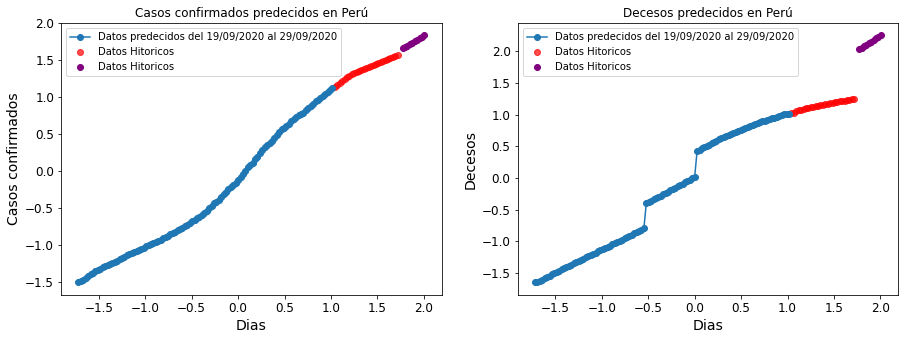

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#plotear casos confirmados 
ax[0].scatter(test_confirmados_peru_testCovid_X[:,1], test_confirmados_peru_testCovid_y, alpha=0.7, c="red", label="Datos Hitoricos")
ax[0].scatter(future_data_peru[:,1], predict_confirmados_peru_future, alpha=1.0, c="purple", label="Datos Hitoricos")
ax[0].plot(train_confirmados_peru_testCovid_X[:,1], train_confirmados_peru_testCovid_y, "-o", label="Datos predecidos del 19/09/2020 al 29/09/2020")
ax[0].set_title("Casos confirmados predecidos en Perú")
ax[0].set_ylabel('Casos confirmados')
ax[0].set_xlabel('Dias')
ax[0].legend()

#plotear decesos 
ax[1].scatter(test_decesos_peru_testCovid_X[:,1], test_decesos_peru_testCovid_y, alpha=0.7, c="red", label="Datos Hitoricos")
ax[1].scatter(future_data_peru[:,1], predict_decesos_peru_future, alpha=1.0, c="purple", label="Datos Hitoricos")
ax[1].plot(train_decesos_peru_testCovid_X[:,1], train_decesos_peru_testCovid_y, "-o", label="Datos predecidos del 19/09/2020 al 29/09/2020")
ax[1].set_title("Decesos predecidos en Perú")
ax[1].set_ylabel('Decesos')
ax[1].set_xlabel('Dias')
ax[1].legend()

Predicción en Arequipa

In [133]:
#predecir casos confirmados
predict_confirmados_aqp_future = predict( future_data_aqp ,theta_confirmados_aqp_testCovid)

In [134]:
#predecir decesos
predict_decesos_aqp_future = predict( future_data_aqp ,theta_decesos_aqp_testCovid)

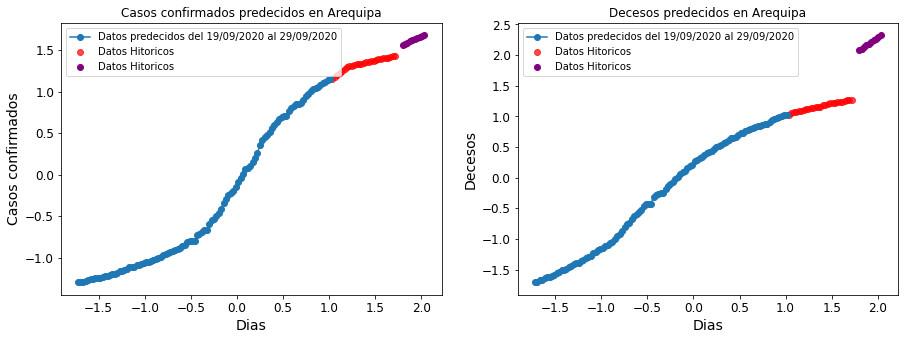

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#plotear casos confirmados 
ax[0].scatter(test_confirmados_aqp_testCovid_X[:,1], test_confirmados_aqp_testCovid_y, alpha=0.7, c="red", label="Datos Hitoricos")
ax[0].scatter(future_data_aqp[:,1], predict_confirmados_aqp_future, alpha=1.0, c="purple", label="Datos Hitoricos")
ax[0].plot(train_confirmados_aqp_testCovid_X[:,1], train_confirmados_aqp_testCovid_y, "-o", label="Datos predecidos del 19/09/2020 al 29/09/2020")
ax[0].set_title("Casos confirmados predecidos en Arequipa")
ax[0].set_ylabel('Casos confirmados')
ax[0].set_xlabel('Dias')
ax[0].legend()

#plotear decesos 
ax[1].scatter(test_decesos_aqp_testCovid_X[:,1], test_decesos_aqp_testCovid_y, alpha=0.7, c="red", label="Datos Hitoricos")
ax[1].scatter(future_data_aqp[:,1], predict_decesos_aqp_future, alpha=1.0, c="purple", label="Datos Hitoricos")
ax[1].plot(train_decesos_aqp_testCovid_X[:,1], train_decesos_aqp_testCovid_y, "-o", label="Datos predecidos del 19/09/2020 al 29/09/2020")
ax[1].set_title("Decesos predecidos en Arequipa")
ax[1].set_ylabel('Decesos')
ax[1].set_xlabel('Dias')
ax[1].legend()

### 3. Recuperar el valor real de la predicción

In [136]:
#=====PERU
#normalizar confirmados
mean = mean_peru_testCovid[2]
standard = standard_peru_testCovid[2]
predict_confirmados_peru_future = predict_confirmados_peru_future * standard + mean

#normalizar decesos
mean = mean_peru_testCovid[3]
standard = standard_peru_testCovid[3]
predict_decesos_peru_future = predict_decesos_peru_future * standard + mean

In [137]:
#=====Arequipa
#normalizar confirmados
mean = mean_aqp_testCovid[2]
standard = standard_aqp_testCovid[2]
predict_confirmados_aqp_future = predict_confirmados_aqp_future * standard + mean

#normalizar decesos
mean = mean_aqp_testCovid[3]
standard = standard_aqp_testCovid[3]
predict_decesos_aqp_future = predict_decesos_aqp_future * standard + mean

# Resultados Perú

Los casos confirmados en Perú entre las fechas <b>19/09/2020</b> y <b>29/09/2020</b> son:

In [138]:
np.set_printoptions(suppress=True)
print(np.round(predict_confirmados_peru_future.T))

[[884937. 889178. 893430. 897693. 901967. 906252. 910549. 914857. 919175.
  923506.]]


Los decesos en Perú entre las fechas <b>19/09/2020</b> y <b>29/09/2020</b> son:

In [139]:
np.set_printoptions(suppress=True)
print(np.round(predict_decesos_peru_future.T))

[[41282. 41520. 41759. 41999. 42239. 42479. 42719. 42960. 43202. 43443.]]


# Resultados Arequipa

Los casos confirmados en Arequipa entre las fechas <b>19/09/2020</b> y <b>29/09/2020</b> son:

In [140]:
np.set_printoptions(suppress=True)
print(np.round(predict_confirmados_aqp_future.T))

[[45410. 45584. 45759. 45933. 46109. 46284. 46460. 46636. 46813. 46989.]]


Los decesos en Arequipa entre las fechas <b>19/09/2020</b> y <b>29/09/2020</b> son:

In [141]:
np.set_printoptions(suppress=True)
print(np.round(predict_decesos_aqp_future.T))

[[1783. 1795. 1808. 1820. 1832. 1845. 1857. 1869. 1882. 1894.]]
